# Classifiers to test the harmonisation

In [1]:
import pandas as pd
import numpy as np
from numpy import random, arange
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, PolynomialFeatures, LabelEncoder

# Import relevant sklearn classes related to machine learning models
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, ElasticNet
from sklearn.svm import SVC, SVR, NuSVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier

# Import relevant sklearn class/function related to evaluation
import sklearn.metrics
from imblearn.under_sampling import RandomUnderSampler

### 0. Data pre-processing

In [2]:
merge = pd.read_csv("../data/ADNIMERGE.csv", low_memory=False)

0              CN
1        Dementia
2        Dementia
3        Dementia
4        Dementia
           ...   
16217          CN
16218          CN
16219         NaN
16220         NaN
16221         NaN
Name: DX, Length: 16222, dtype: object

## I. Basic diagnosis predictor

In [43]:
basic_diagnosis_features = pd.concat([merge['AGE'], merge['PTGENDER'], merge['MMSE'], merge['APOE4'], merge['DX']], axis=1)
basic_diagnosis_features.head()

,AGE,PTGENDER,MMSE,APOE4,DX
0,74.3,Male,28.0,0.0,CN
1,81.3,Male,20.0,1.0,Dementia
2,81.3,Male,24.0,1.0,Dementia
3,81.3,Male,17.0,1.0,Dementia
4,81.3,Male,19.0,1.0,Dementia


In [44]:
gender_encoder = LabelEncoder()
new_gender = gender_encoder.fit_transform(basic_diagnosis_features['PTGENDER'])
diagnostic = np.where(basic_diagnosis_features['DX'] == 'Dementia',1,0)

basic_diagnosis_features['PTGENDER'] = new_gender
basic_diagnosis_features['DX'] = diagnostic

basic_diagnosis_features = basic_diagnosis_features.dropna()

In [45]:
Y = basic_diagnosis_features['DX']
#base.drop(['DX_bl'])
basic_diagnosis_features.drop(['DX'], axis=1, inplace=True)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(basic_diagnosis_features, Y, test_size=0.4, train_size=0.6)

### Cross validation - Model selection & hyperparameter tuning

In [54]:
models = [GradientBoostingClassifier(), RandomForestClassifier(), SVC(), DecisionTreeClassifier(), MLPClassifier()]
kfold = KFold(n_splits=10)
for model in models:
    cv_results = cross_val_score(model, basic_diagnosis_features, Y, cv=kfold, scoring='accuracy', n_jobs=-1)
    print(model, cv_results.sum()/10)

GradientBoostingClassifier() 0.8971112681662727
RandomForestClassifier() 0.8745855774620427
SVC() 0.8958500069050114
DecisionTreeClassifier() 0.8666574058278297
MLPClassifier() 0.8914358361968822


In [58]:
CV_gb_combined = GridSearchCV(estimator=GradientBoostingClassifier() ,param_grid={'learning_rate':arange(0.1,1,0.1), 'max_depth':range(1,10)}, scoring="accuracy", n_jobs=-1, cv=kfold)
CV_gb_combined.fit(basic_diagnosis_features, Y)
print(CV_gb_combined.best_score_)

print(CV_gb_combined.best_params_)

0.8984630256947661

In [60]:

print(CV_gb_combined.best_params_)

{'learning_rate': 0.1, 'max_depth': 2}


<AxesSubplot:>

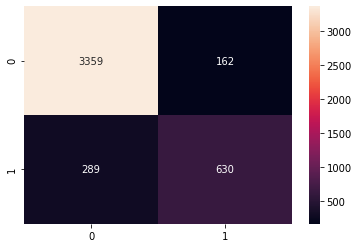

In [61]:

gb = GradientBoostingClassifier( learning_rate=0.1, max_depth=2)
gb.fit(X_train, y_train)

results = gb.predict(X_test)
x = zip(results, y_test)

cf_matrix = sklearn.metrics.confusion_matrix(y_test, results)
sns.heatmap(cf_matrix, annot=True, fmt='g')


In [62]:
balanced_accuracy_score(y_test, results)

0.8197590456020291

## II. Evolution predictor

In [3]:
merge2 = pd.concat([merge['AGE'], merge['PTGENDER'], merge['MMSE'], merge['APOE4'], merge['DX'], merge['PTID']], axis=1)
firstvisits = ~merge2.duplicated(subset=['PTID'], keep='first')
lastvisits = ~merge2.duplicated(subset=['PTID'], keep='last')

first = merge2.loc[firstvisits].copy()

last = merge2.loc[lastvisits]
last = pd.concat([last['DX'], last['PTID']], axis=1)
last.rename(columns={"DX": "DX_f"}, inplace=True)








In [4]:
evol = first.merge(last, left_on='PTID', right_on='PTID').dropna()
evol.head()

,AGE,PTGENDER,MMSE,APOE4,DX,PTID,DX_f
0,74.3,Male,28.0,0.0,CN,011_S_0002,MCI
5,75.4,Male,20.0,1.0,Dementia,022_S_0007,Dementia
8,80.8,Male,29.0,1.0,CN,100_S_0015,MCI
10,72.6,Female,30.0,0.0,CN,011_S_0021,CN
11,71.7,Male,26.0,0.0,CN,011_S_0023,CN


In [5]:
evol.drop(['PTID'], axis=1, inplace=True)
evol_mci = evol.drop(evol[evol['DX'] != 'MCI'].index)

In [6]:
gender_encoder = LabelEncoder()
new_gender = gender_encoder.fit_transform(evol_mci['PTGENDER'])
diagnostic = np.where(evol_mci['DX_f'] == 'Dementia',1,0)

evol_mci['PTGENDER'] = new_gender
evol_mci['DX_f'] = diagnostic

evol_mci = evol_mci.dropna()

In [7]:
evol_mci = evol_mci.drop(['DX'], axis=1)

In [8]:
Y = evol_mci['DX_f']
X = evol_mci.drop(['DX_f'], axis=1)

In [9]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, Y, test_size=0.4, train_size=0.6)

### Model and hyperparameter selection

In [15]:
models = [GradientBoostingClassifier(), RandomForestClassifier(), SVC(), DecisionTreeClassifier(), MLPClassifier()]
kfold = KFold(n_splits=10)
for model in models:
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='balanced_accuracy', n_jobs=-1)
    print(model, cv_results.sum()/10)

GradientBoostingClassifier() 0.5100282717664355
RandomForestClassifier() 0.5233049726600926
SVC() 0.5
DecisionTreeClassifier() 0.5323536611120873
MLPClassifier() 0.5047564561552914


In [12]:
CV_mlp_combined = GridSearchCV(estimator=MLPClassifier() ,param_grid={'hidden_layer_sizes':range(1,10)}, scoring="balanced_accuracy", n_jobs=-1, cv=kfold)
CV_mlp_combined.fit(X, Y)
print(CV_mlp_combined.best_score_)

print(CV_mlp_combined.best_params_)

0.5286278710531901
{'hidden_layer_sizes': 7}


C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<AxesSubplot:>

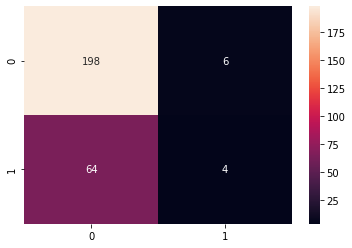

In [16]:
rf = MLPClassifier()
rf.fit(X_train2, y_train2)

results2 = rf.predict(X_test2)
x = zip(results2, y_test2)

cf_matrix2 = sklearn.metrics.confusion_matrix(y_test2, results2)
sns.heatmap(cf_matrix2, annot=True, fmt='g')

In [17]:
balanced_accuracy_score(y_test2, results2)

0.5147058823529411

<AxesSubplot:>

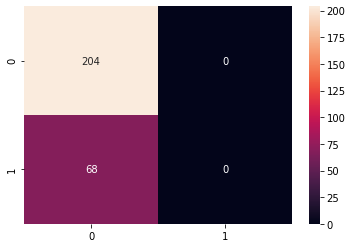

In [13]:
mlp = MLPClassifier( hidden_layer_sizes=7)
mlp.fit(X_train2, y_train2)

results2 = mlp.predict(X_test2)
x = zip(results2, y_test2)

cf_matrix2 = sklearn.metrics.confusion_matrix(y_test2, results2)
sns.heatmap(cf_matrix2, annot=True, fmt='g')

In [14]:
balanced_accuracy_score(y_test2, results2)

0.5

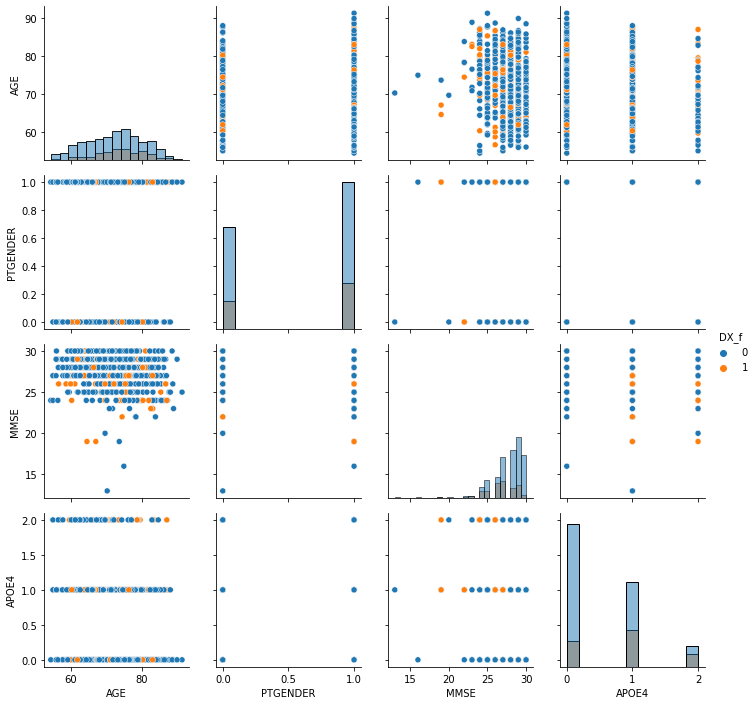

In [21]:
X2 = X.copy()
X2['DX_f'] = Y
g = sns.PairGrid(X2, hue="DX_f")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()